<a href="https://colab.research.google.com/github/UdaraChamidu/Eye-Disease-Classification-With-Integrated-Chatbot/blob/main/eye_diseases_classification_inceptionv3_95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Eye Diseases Classification

In this notebook we study eye diseases classification. Our model focuses on four main classes of eye diseases:

#### Cataract
Cataract is a disease in which the lens of the eye becomes cloudy, leading to vision loss. It is usually associated with aging, but some health conditions, such as diabetes, can also be a risk factor. Cataracts can significantly reduce the quality of vision, but can be treated with surgery.

### Diabetic Retinopathy
Diabetic retinopathy is a complication of diabetes that results from damage to the retinal vessels in the eye. It may be asymptomatic in the early stages, but as it progresses, it can lead to vision loss. If left untreated, it increases the risk of blindness.

### Glaucoma (Glaucoma)
Glaucoma refers to a group of eye diseases that damage the optic nerve in the eye, leading to vision loss. It is usually associated with elevated intraocular pressure. If not diagnosed early, it can cause permanent vision loss. Treatment can be with medication or surgery.

#### Normal (Healthy Eye)
Healthy eyes are eyes that do not show any signs of disease or discomfort. This class represents individuals without any pathologic condition in the eye.

---

## Libraries 📚

In [ ]:
!pip install -q visualkeras
import visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 18.4 MB/s eta 0:00:00


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = info, 2 = warning, 3 = error

In [ ]:
# system libs
import os
import time
import shutil
import pathlib
import itertools

import random
import pandas as pd
import numpy as np

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

print ('LIBS ARE IMPORTED')

LIBS ARE IMPORTED


In [ ]:
# Evaluation Lib.
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

In [ ]:
import tensorflow as tf
print("Tensorflow version ",tf.__version__)

Tensorflow version  2.18.0


In [ ]:
import os
from google.colab import drive

#  Mount Google Drive
drive.mount('/content/drive')

#  Define dataset path inside Google Drive
dataset_dir = '/content/drive/MyDrive/old_state_of_art/dataset'

#  Get class names from the dataset directory
class_names = sorted(os.listdir(dataset_dir))
num_class = len(class_names)

#  Print results
print(f"Class Names: {class_names}")
print(f"Number of Classes: {num_class}")

Mounted at /content/drive
Class Names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of Classes: 4


In [ ]:
from PIL import Image

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the image path in Drive
image_path = '/content/drive/MyDrive/old_state_of_art/dataset/glaucoma/Glaucoma_101.png'

# 3. Open image and get dimensions
im = Image.open(image_path)
width, height = im.size

print(f"width: {width}, height: {height}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
width: 2464, height: 1632


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(256, 256),
    seed=42,
)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [ ]:
def learn_label_counts(dataset,class_names):
    train_labels = np.concatenate([y for x,y in dataset], axis=0)
    values = pd.value_counts(train_labels)
    values = values.sort_index()

    print("Label Distribution:")
    for idx,count in values.items():
        print(f"{class_names[idx]} ({idx}): {count}")

    print("=="*50)
    data_iterator = dataset.as_numpy_iterator()
    batch = data_iterator.next()
    print("Batch Shape:",batch[0].shape)

    print("=="*50)
    plt.figure(figsize=(12,8))
    plt.pie(values,autopct='%1.1f%%', explode = [0.02,0.02,0.02, 0.02], textprops = {"fontsize":15})
    plt.legend(labels=class_names)
    plt.show()

Label Distribution:
cataract (0): 836
diabetic_retinopathy (1): 884
glaucoma (2): 802
normal (3): 852
Batch Shape: (32, 256, 256, 3)


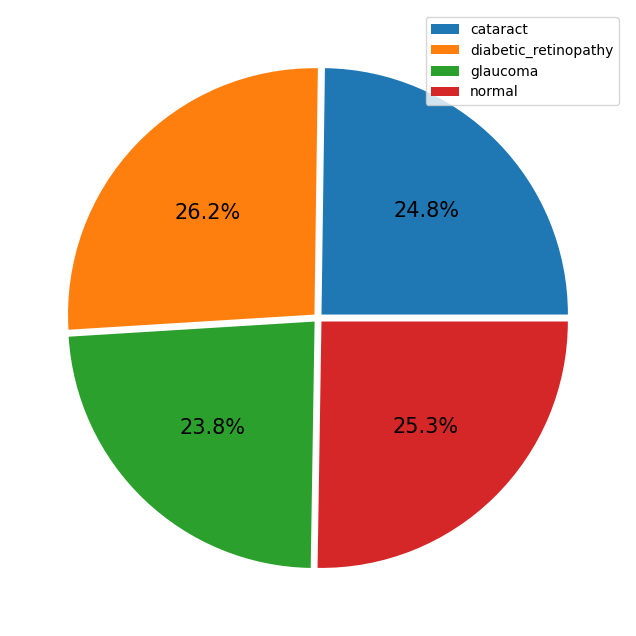

In [ ]:
learn_label_counts(train_ds,class_names)

Label Distribution:
cataract (0): 204
diabetic_retinopathy (1): 217
glaucoma (2): 201
normal (3): 221
Batch Shape: (32, 256, 256, 3)


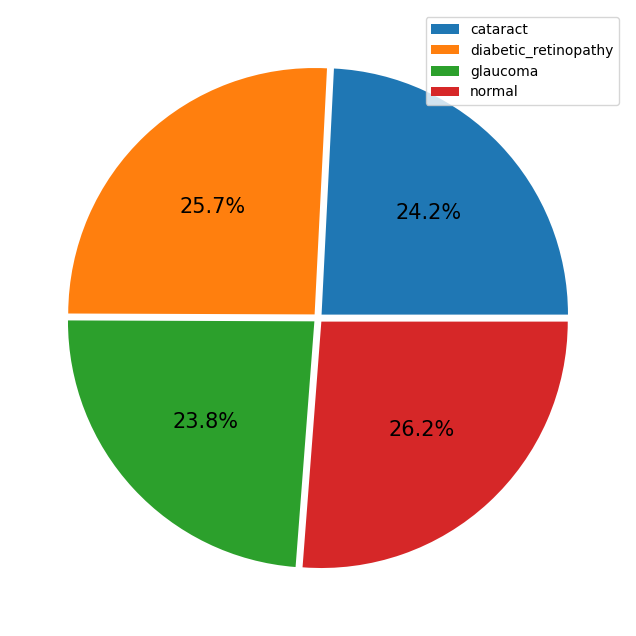

In [ ]:
learn_label_counts(val_ds,class_names)

In [ ]:
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
print("Shape of the first image in the validation dataset:", next(iter(val_ds))[0][0].shape)

Shape of the first image in the training dataset: (256, 256, 3)
Shape of the first image in the validation dataset: (256, 256, 3)


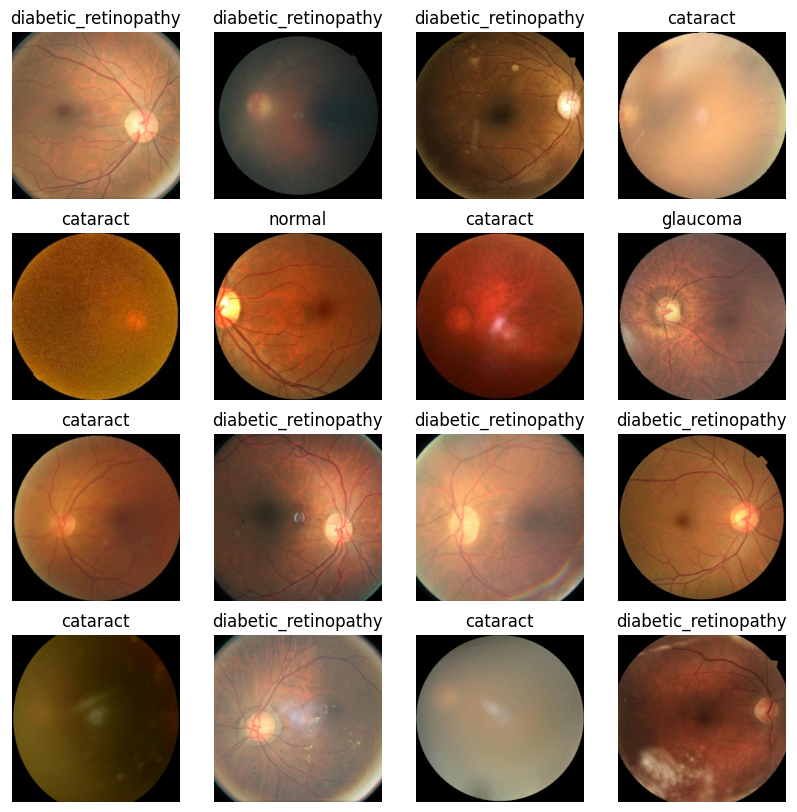

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def visualize_images(path, target_size=(256, 256), num_images=5):
    """
    Visualize random images from a given directory.

    Args:
        path (str): Directory containing images.
        target_size (tuple): Desired image size for visualization.
        num_images (int): Number of images to display.

    Raises:
        ValueError: If no valid image files are found in the directory.
    """
    # Only allow common image formats
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    image_filenames = [f for f in os.listdir(path)
                       if f.lower().endswith(valid_extensions) and os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    print("=="*50)
    print(path.split('/')[-1].upper())
    print("--"*50)

    # Randomly select images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create subplots
    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 3), facecolor='white')

    # Handle case when only one image (axes is not iterable)
    if len(selected_images) == 1:
        axes = [axes]

    for i, image_filename in enumerate(selected_images):
        try:
            # Load and resize image
            image_path = os.path.join(path, image_filename)
            image = Image.open(image_path).convert("RGB")  # ensure RGB mode
            image = image.resize(target_size)

            # Display image
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(image_filename, fontsize=8)
        except Exception as e:
            axes[i].axis('off')
            axes[i].set_title("Error", fontsize=8)
            print(f"Error loading {image_filename}: {e}")

    plt.tight_layout()
    plt.show()

    print("=="*50)

GLAUCOMA
----------------------------------------------------------------------------------------------------


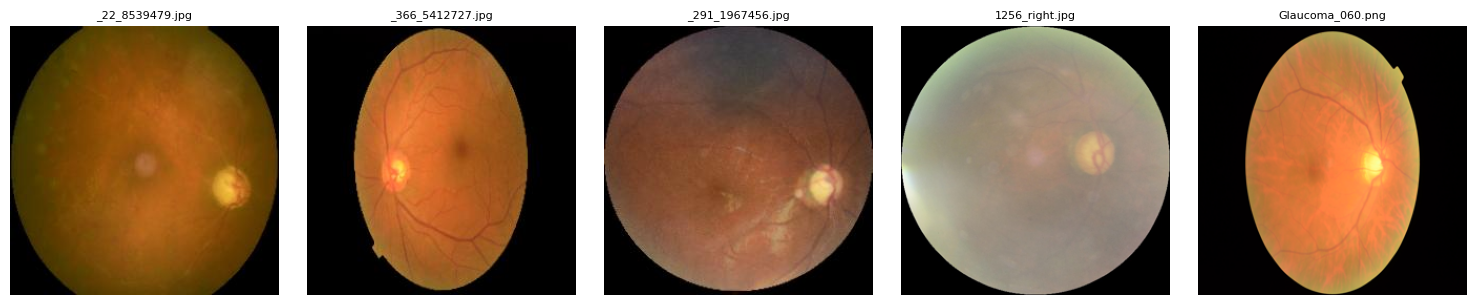

In [ ]:
path_to_visualize = "/content/drive/MyDrive/old_state_of_art/dataset/glaucoma"
visualize_images(path_to_visualize, num_images=5)

DIABETIC_RETINOPATHY
----------------------------------------------------------------------------------------------------


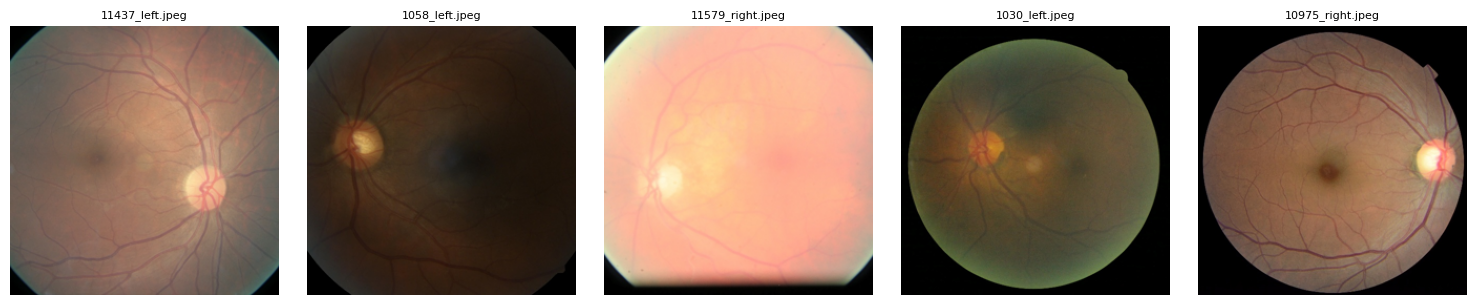

In [ ]:
path_to_visualize = "/content/drive/MyDrive/old_state_of_art/dataset/diabetic_retinopathy"
visualize_images(path_to_visualize, num_images=5)

GLAUCOMA
----------------------------------------------------------------------------------------------------


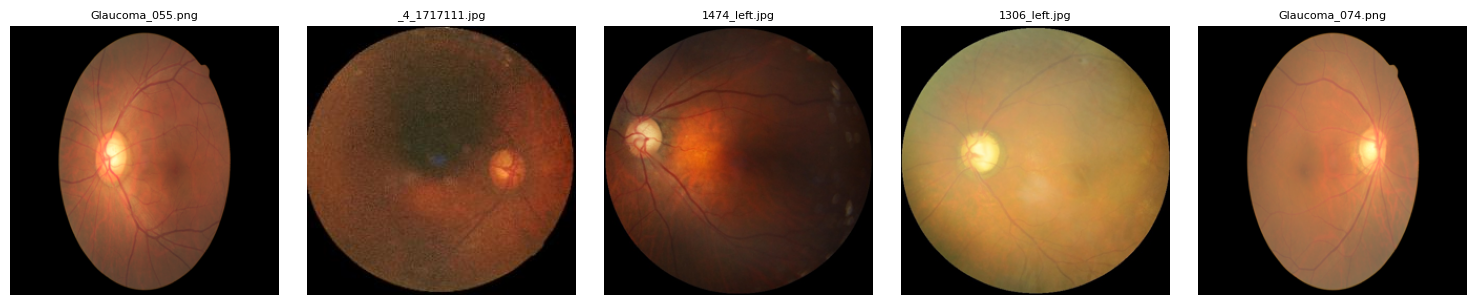

In [ ]:
path_to_visualize = "/content/drive/MyDrive/old_state_of_art/dataset/glaucoma"
visualize_images(path_to_visualize, num_images=5)

NORMAL
----------------------------------------------------------------------------------------------------


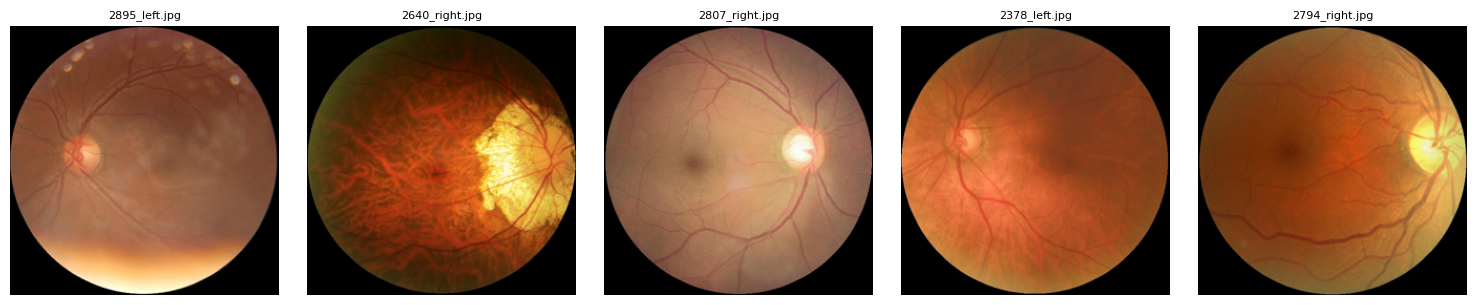

In [ ]:
path_to_visualize = "/content/drive/MyDrive/old_state_of_art/dataset/normal"
visualize_images(path_to_visualize, num_images=5)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),  # Flip image horizontally (suitable for symmetric organs like eyes)
    tf.keras.layers.RandomRotation(0.1),       # Small rotation (0.1 ~ ±10%) to avoid unrealistic deformation
    tf.keras.layers.RandomZoom(0.1),           # Slight zoom in/out
    tf.keras.layers.RandomContrast(0.1),       # Vary contrast to simulate lighting differences
    tf.keras.layers.RandomBrightness(0.1),     # Simulate different brightness levels
    tf.keras.layers.RandomTranslation(0.1, 0.1), # Slight translation (up/down, left/right)
    tf.keras.layers.GaussianNoise(0.05),       # Add random noise to simulate sensor noise
])

## Inception Model and Layer Additions
In this project, we used the pre-trained **InceptionV3** model. **InceptionV3** is a deep learning model that is highly successful in visual classification tasks. However, we didn't just output the base model, instead we stopped the last layers of the model and added our own custom layers.

The purpose of stopping the final layers of the model is to leverage the feature extraction capacity of the pre-trained model, but customize the final classification layers to our specific classification of eye diseases.

#### Layers We Added:
At the end of the model, we added **Dense** layers to classify the eye disease classes appropriately. We also performed multiclass classification using **softmax** activation function in the last layer. This allows us to accurately predict between four different classes (Cataract, Diabetic Retinopathy, Glaucoma, Normal).

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 Tru

In [ ]:
from tensorflow.keras import Model
cut_layer = base_model.get_layer('mixed8')
truncated_model = Model(inputs=base_model.input, outputs=cut_layer.output)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import preprocess_input

truncated_model.trainable = True

# --- Build model with Functional API
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)              # Veri artırımı
x = preprocess_input(x)                    # Modelin beklediği format
x = truncated_model(x, training=True)     # Transfer learning bloğu
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 6, 6, 1280)     │    10,674,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 6, 6, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 6, 6, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,987,236 (53.36 MB)

 Trainable params: 13,965,092 (53.27 MB)

 Non-trainable params: 22,144 (86.50 KB)

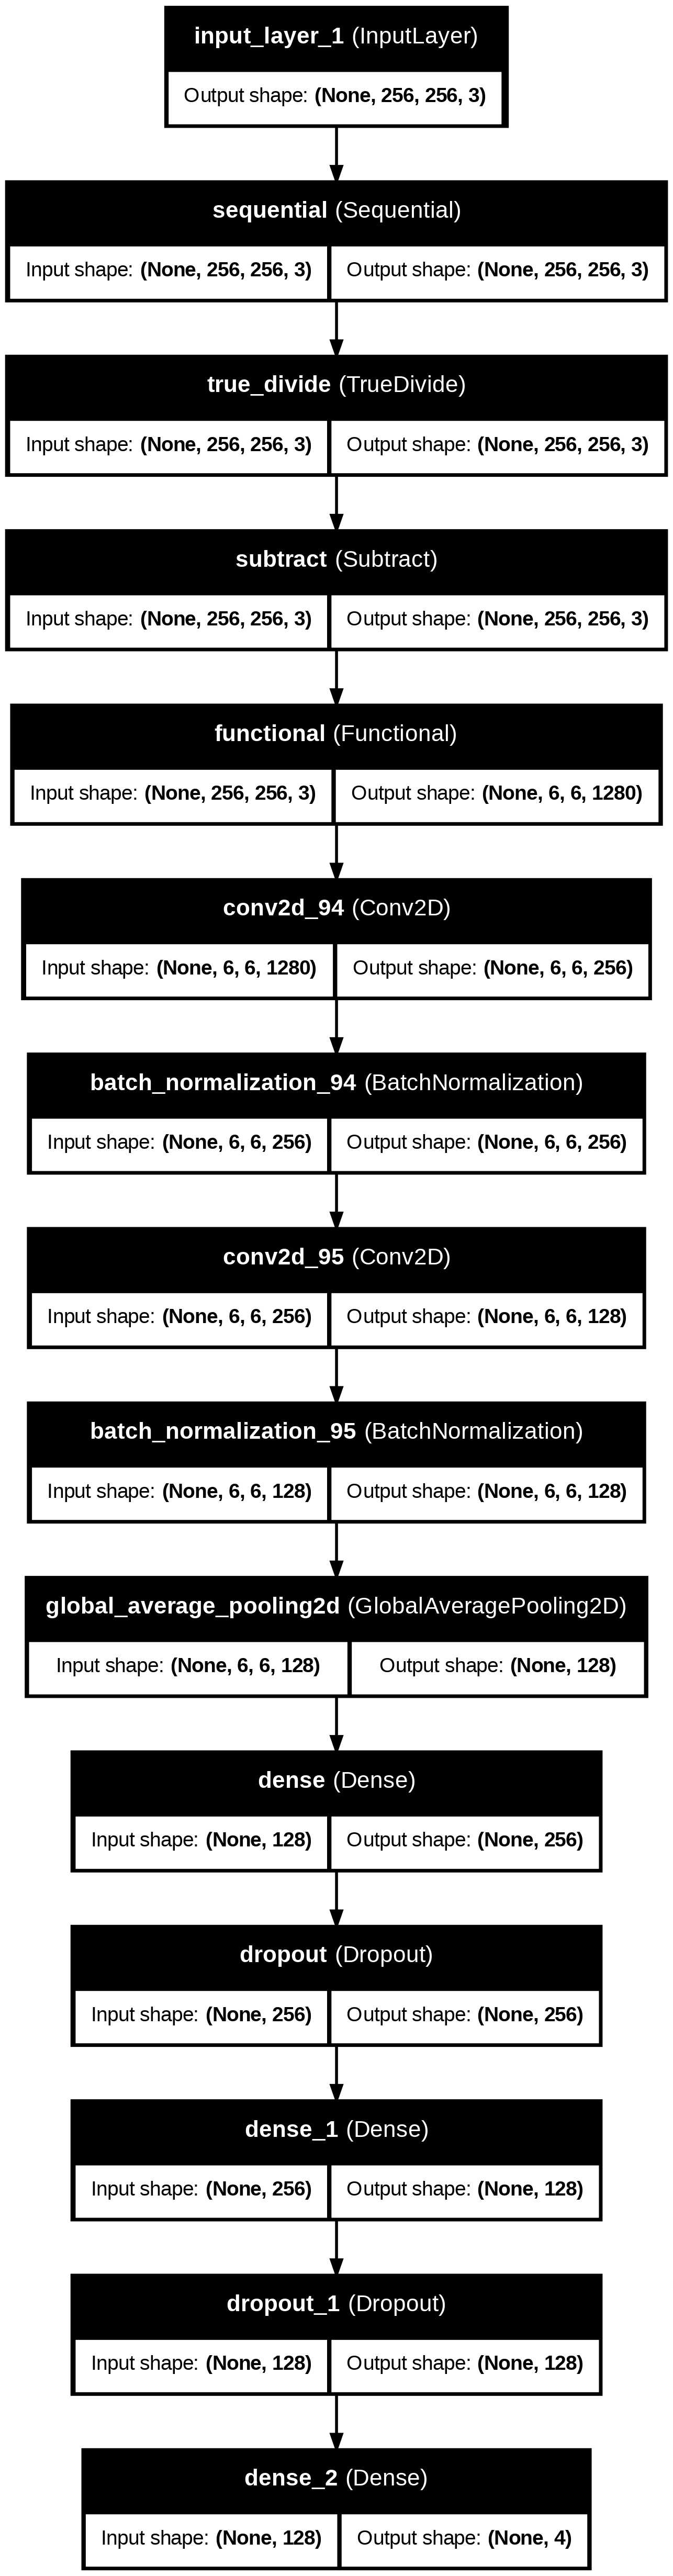

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

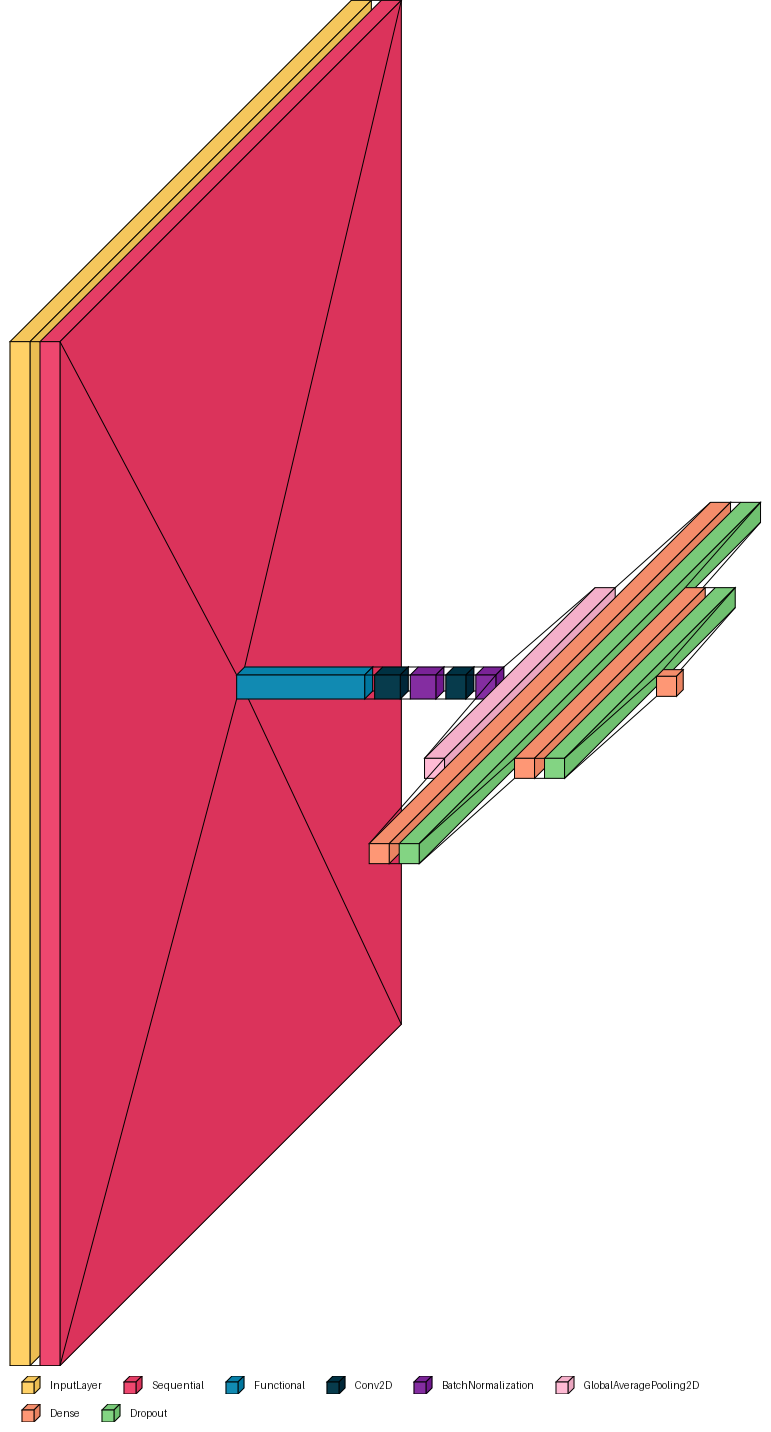

In [ ]:
visualkeras.layered_view(model,legend=True,one_dim_orientation='x')

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(zip(np.unique(labels), class_weights))
print(class_weight_dict)

{np.int32(0): np.float64(1.0089712918660287), np.int32(1): np.float64(0.954185520361991), np.int32(2): np.float64(1.0517456359102244), np.int32(3): np.float64(0.9900234741784038)}


In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.F1Score(average='macro', name='f1_score')
    ]
)

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
    TensorBoard, LearningRateScheduler
)

def lr_schedule(epoch):
    initial_lr = 0.001
    drop_factor = 0.5
    drop_every = 5  # Her 5 epoch'ta bir öğrenme oranını yarıya düşür
    lr = initial_lr * (drop_factor ** (epoch // drop_every))
    return lr


model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max',  # 'max' for accuracy, 'min' for loss
    save_freq='epoch',
    save_weights_only=False  # Tüm modeli kaydet
)


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    mode='max',
    verbose=1,
    restore_best_weights=True,
    baseline=0.99,  # Belirli bir doğruluk değerine ulaşılırsa durdur
    min_delta=0.001  # İyileşme bu değerden küçükse durdur
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=1e-6,
    epsilon=0.001  # Öğrenme oranındaki değişiklik için eşik değer
)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping,model_checkpoint,lr_scheduler],
    verbose=1,
    class_weight = class_weight_dict
)

Epoch 1/20
 32/106 ━━━━━━━━━━━━━━━━━━━━ 27:51 23s/step - accuracy: 0.5026 - auc: 0.7653 - f1_score: 0.4879 - loss: 1.1120 - precision: 0.6445 - recall: 0.2635

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-32-3129952753.py", line 1, in <cell line: 0>
    history = model.fit(
              ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
    opt_outputs = multi_step_on_iterator(iterator)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in e

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

In [ ]:
history_dict = history.history

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
# Plot training history
plt.plot(history.history['loss'], label='Training Loss',marker='x')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Precision, Recall, F1 Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['precision'], label='Train Precision')
plt.plot(history_dict['val_precision'], label='Val Precision')
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['recall'], label='Train Recall')
plt.plot(history_dict['val_recall'], label='Val Recall')
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['f1_score'], label='Train F1 Score')
plt.plot(history_dict['val_f1_score'], label='Val F1 Score')
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

In [ ]:
results = model.evaluate(val_ds, return_dict=True)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
from sklearn.metrics import roc_curve, auc

y_true = []
y_pred = []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch)
    preds = np.argmax(preds, axis=1)  # Tahminleri multiclass yap!

    # y_batch'in one-hot olduğu için multiclass'a çevir!
    y_true_batch = np.argmax(y_batch.numpy(), axis=1) if y_batch.numpy().ndim > 1 else y_batch.numpy()

    y_true.extend(y_true_batch)
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
print(y_pred)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"],
                      show_normed = True);
plt.savefig("Predected & True Label.png")

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Actual')
plt.yticks(rotation=0, ha='right')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

In [ ]:
y_pred_prob = model.predict(val_ds)

In [ ]:
y_true = []
y_pred_proba = []

for x_batch, y_batch in val_ds:
    probs = model.predict(x_batch)  # Olasılık çıktıları (softmax)
    y_true_batch = np.argmax(y_batch.numpy(), axis=1) if y_batch.numpy().ndim > 1 else y_batch.numpy()

    y_true.extend(y_true_batch)
    y_pred_proba.extend(probs)

y_true = np.array(y_true)  # Multiclass etiketler
y_pred_proba = np.array(y_pred_proba)  # Olasılıklar [n_samples, n_classes]

# Sınıf sayısını belirle
n_classes = y_pred_proba.shape[1]

# Gerçek etiketleri one-hot encode et (OvR için)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Her sınıf için ROC eğrisi ve AUC hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Makro-ortalama ROC eğrisi hesapla (opsiyonel)
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ROC eğrilerini çiz
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Sınıf sayısı kadar renk
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Makro-ortalama ROC eğrisini ekle
plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', lw=2,
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})')

# Şansa bağlı çizgi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Grafik ayarları
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Batch boyutu ekle

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)  # Yüzde olarak, 2 ondalık
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Tahmin yap
        predicted_class, confidence = predict(model, images[i].numpy())
        # Gerçek sınıfı al (labels[i] tensor, numpy'ya çevir)
        actual_class = class_names[labels[i].numpy()] if labels[i].numpy().ndim == 0 else class_names[np.argmax(labels[i].numpy())]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}\n Confidence: {confidence}%")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

class_names = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']

img_path = '/content/drive/MyDrive/old_state_of_art/dataset/diabetic_retinopathy/1000_right.jpeg'

img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

pred = model.predict(img_array)
predicted_class = np.argmax(pred[0])
confidence = np.max(pred[0])

print(f"Tahmin edilen sınıf: {class_names[predicted_class]} ({confidence*100:.2f}%)")

plt.imshow(img)
plt.title(f"Tahmin: {class_names[predicted_class]}")
plt.axis('off')
plt.show()

In [ ]:
control_dir = "/content/drive/MyDrive/old_state_of_art/dataset/normal"

for name in os.listdir(control_dir)[:10]:
    print(name)
    class_names = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']

    img_path  = os.path.join(control_dir,name)

    img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred[0])
    confidence = np.max(pred[0])

    print(f"Tahmin edilen sınıf: {class_names[predicted_class]} ({confidence*100:.2f}%)")

    plt.imshow(img)
    plt.title(f"Tahmin: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()
